In [0]:
import numpy as np 
import pandas as pd

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv('/content/drive/My Drive/task5/train.csv')

In [0]:
test = pd.read_csv('/content/drive/My Drive/task5/test.csv')


In [10]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [11]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [0]:
target = train[['healthy', 'multiple_diseases', 'rust', 'scab']]
test_id = test['image_id']
train_len = train.shape[0]
test_len = test.shape[0]

In [13]:
test_id


0          Test_0
1          Test_1
2          Test_2
3          Test_3
4          Test_4
          ...    
1816    Test_1816
1817    Test_1817
1818    Test_1818
1819    Test_1819
1820    Test_1820
Name: image_id, Length: 1821, dtype: object

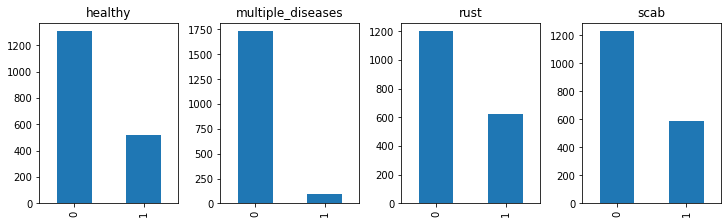

In [14]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(10, 3))
for ax, column in zip(axes, ['healthy', 'multiple_diseases', 'rust', 'scab']):
    target[column].value_counts().plot.bar(title=column, ax=ax)
plt.show()

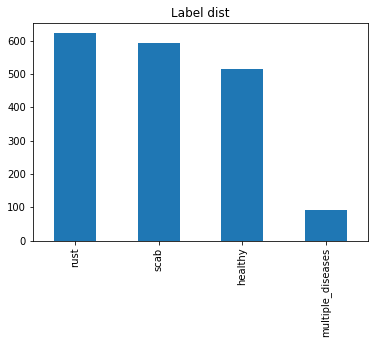

In [15]:
plt.title('Label dist')
target[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1).value_counts().plot.bar()

In [16]:
from PIL import Image
from tqdm.notebook import tqdm

SIZE = 224

train_images = np.empty((train_len, SIZE, SIZE, 3))
for i in tqdm(range(train_len)):
    train_images[i] = np.uint8(Image.open(f'/content/drive/My Drive/task5/images/Train_{i}.jpg').resize((SIZE, SIZE)))
    
test_images = np.empty((test_len, SIZE, SIZE, 3))
for i in tqdm(range(test_len)):
    test_images[i] = np.uint8(Image.open(f'/content/drive/My Drive/task5/images/Test_{i}.jpg').resize((SIZE, SIZE)))


In [17]:



train_images.shape, test_images.shape

((1821, 224, 224, 3), (1821, 224, 224, 3))

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_images, target.to_numpy(), test_size=0.2, random_state=289) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1456, 224, 224, 3), (365, 224, 224, 3), (1456, 4), (365, 4))

In [19]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=289)

x_train, y_train = ros.fit_resample(x_train.reshape((-1, SIZE * SIZE * 3)), y_train)
x_train = x_train.reshape((-1, SIZE, SIZE, 3))
x_train.shape, y_train.sum(axis=0)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((1968, 224, 224, 3), array([492, 492, 492, 492]))

In [20]:
from keras.models import Model, Sequential, load_model, Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.regularizers import l2

rlr = ReduceLROnPlateau(patience=15, verbose=1)
es = EarlyStopping(patience=35, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('model.hdf5', save_best_only=True, verbose=0)

filters = 32
reg = .0005

model = Sequential()
model.add(Conv2D(filters, 3, kernel_regularizer=l2(reg), input_shape=(SIZE, SIZE, 3)))
model.add(LeakyReLU())
    
model.add(Conv2D(filters, 3, kernel_regularizer=l2(reg)))
model.add(LeakyReLU())   
       
model.add(MaxPooling2D())
#model.add(Dropout(0.5))
model.add(BatchNormalization())
   
model.add(Flatten())
model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 110, 110, 32)      128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 387200)           

In [21]:
from keras.preprocessing.image import ImageDataGenerator

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

imagegen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

history = model.fit_generator(
    imagegen.flow(x_train, y_train, batch_size=32),
    epochs=400,
    steps_per_epoch=x_train.shape[0] // 32,
    verbose=0,
    callbacks=[rlr, es, mc],
    validation_data=(x_test, y_test)
)
# load best model
model = load_model('model.hdf5')
model.save('/content/drive/My Drive/task5/model.hdf5')


Epoch 00103: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00136: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00151: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00156: early stopping


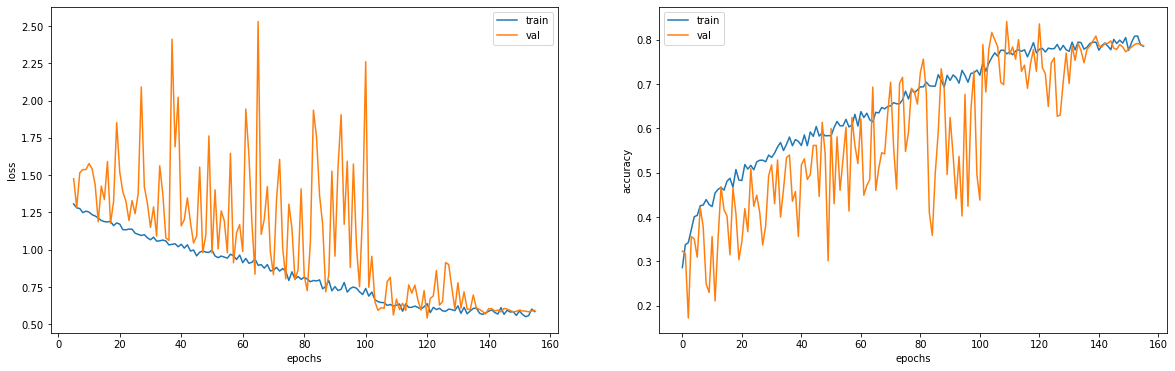

In [22]:
from matplotlib import pyplot as plt

h = history.history

offset = 5
epochs = range(offset, len(h['loss']))

plt.figure(1, figsize=(20, 6))

plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, h['loss'][offset:], label='train')
plt.plot(epochs, h['val_loss'][offset:], label='val')
plt.legend()

plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(h[f'acc'], label='train')
plt.plot(h[f'val_acc'], label='val')
plt.legend()

plt.show()

In [23]:
rlr2 = ReduceLROnPlateau(patience=15, verbose=1)
es2 = EarlyStopping(patience=35, restore_best_weights=True, verbose=1)
mc2 = ModelCheckpoint('model2.hdf5', save_best_only=True, verbose=0)

filters = 32
reg = .0005

model2 = Sequential()
model2.add(Conv2D(filters, 3, kernel_regularizer=l2(reg), input_shape=(SIZE, SIZE, 3)))
model2.add(LeakyReLU())
    
model2.add(Conv2D(filters, 3, kernel_regularizer=l2(reg)))
model2.add(LeakyReLU())   
       
model2.add(MaxPooling2D())
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
   
model2.add(Flatten())
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(4, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 110, 110, 32)     

In [30]:
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

imagegen2 = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

history2 = model2.fit_generator(
    imagegen.flow(x_train, y_train, batch_size=32),
    epochs=400,
    steps_per_epoch=x_train.shape[0] // 32,
    verbose=0,
    callbacks=[rlr, es, mc],
    validation_data=(x_test, y_test)
)



Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00060: early stopping


In [0]:
#model2 = load_model('model.hdf5')
model2.save('/content/drive/My Drive/task5/model2.hdf5')


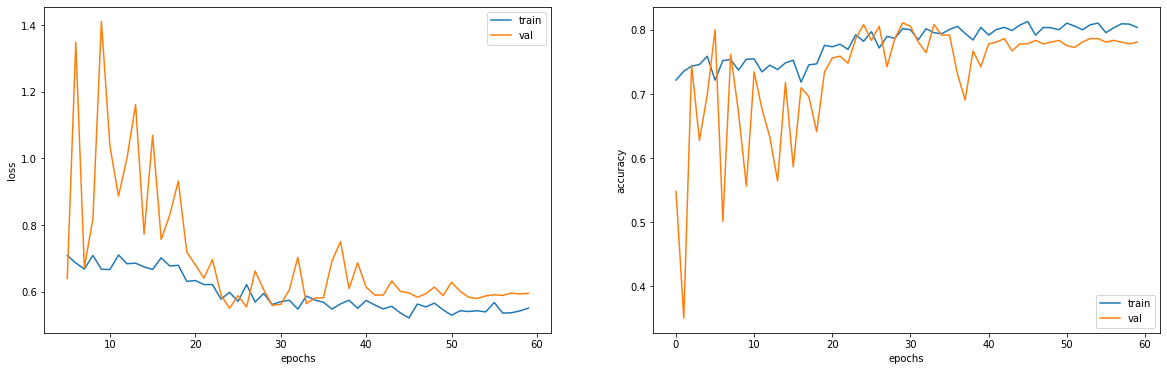

In [32]:
h2 = history2.history

offset = 5
epochs = range(offset, len(h2['loss']))

plt.figure(1, figsize=(20, 6))

plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, h2['loss'][offset:], label='train')
plt.plot(epochs, h2['val_loss'][offset:], label='val')
plt.legend()

plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(h2[f'acc'], label='train')
plt.plot(h2[f'val_acc'], label='val')
plt.legend()

plt.show()

In [46]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img,img_to_array


new_model = load_model('/content/drive/My Drive/task5/model2.hdf5')

layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_dict

{'batch_normalization_1': <keras.layers.normalization.BatchNormalization at 0x7fae7aac1c88>,
 'batch_normalization_2': <keras.layers.normalization.BatchNormalization at 0x7fae77a89668>,
 'conv2d_1': <keras.layers.convolutional.Conv2D at 0x7fae7aac16a0>,
 'conv2d_2': <keras.layers.convolutional.Conv2D at 0x7fae77a83b38>,
 'dense_1': <keras.layers.core.Dense at 0x7faedeb75b38>,
 'dense_2': <keras.layers.core.Dense at 0x7faedeb75a90>,
 'flatten_1': <keras.layers.core.Flatten at 0x7faedeb75390>,
 'leaky_re_lu_1': <keras.layers.advanced_activations.LeakyReLU at 0x7fae77a83e10>,
 'leaky_re_lu_2': <keras.layers.advanced_activations.LeakyReLU at 0x7fae77a89898>,
 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D at 0x7fae77a899b0>}

In [45]:
layer_name = 'max_pooling2d_1'

new_model = Model(inputs=new_model.inputs, outputs=layer_dict[layer_name].output)

# Perpare the image
image = load_img('/content/drive/My Drive/task5/images/Test_1.jpg', plant_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# Apply the model to the image
feature_maps = new_model.predict(image)

square = 8
index = 1
for _ in range(square):
	for _ in range(square):
        
		ax = plt.subplot(square, square, index)
		ax.set_xticks([])
		ax.set_yticks([])

		plt.imshow(feature_maps[0, :, :, index-1], cmap='viridis')
		index += 1
        
plt.show()

ValueError: ignored

NameError: ignored

In [0]:
From the data we see an unequal distribution by classes. most leaves in the dataset are unhealthy. applying dropout, I noticed that the speed of training the neural network was significantly accelerated

**From the data we see an unequal distribution by classes. most leaves in the dataset are unhealthy. applying dropout, I noticed that the speed of training the neural network was significantly accelerated.**





